In [1]:
from symbolic_regression.methods.gp import GP
from symbolic_regression.utils.pysr_utils import nrmse_loss, train_val_test_split
from symbolic_regression.datasets import load_datasets

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set_theme()
warnings.filterwarnings("ignore", category=UserWarning, module="pysr")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
n_runs = 10

pysr_params = {
    "populations": 1,
    "population_size": 20,
    "niterations": 50,
    "binary_operators": ["+", "-", "*"],
    "unary_operators": ["sqrt", "inv(x) = 1/x"],
    "extra_sympy_mappings": {"inv": lambda x: 1/x},
    "verbosity": 0
}

basic_params = {
    "loss_function": nrmse_loss,
    "record_interval": 5,
    "pysr_params": pysr_params,
}

dataset_names = [
    "F1",
    # "F2",
    # ("4544_GeographicalOriginalofMusic", "4544_GOM"),
    # "505_tecator",
    # ("Communities and Crime", "CCN"),
    # ("Communities and Crime Unnormalized", "CCUN"),
]

datasets = load_datasets(dataset_names)
width = max([round(len(name)+10, -1) for name in datasets.keys()])

datasets.keys()

dict_keys(['F1'])

In [19]:
gp = GP(**basic_params)
n_records = gp.n_records

methods = {
    "GP": gp,
}

In [22]:
results = {}
equations = {}
features = {}

for dataset_name, dataset in datasets.items():
    results[dataset_name] = {}
    equations[dataset_name] = {}
    features[dataset_name] = {}

    X = dataset["X"]
    y = dataset["y"]
    train_val_test_set = train_val_test_split(X, y)

    for method_name, method in methods.items():
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []

        print(f"Running {method_name} on {dataset_name:<{width}}", end="")

        for run in range(n_runs):
            print(".", end="")

            temp_training_losses, temp_validation_losses, temp_test_losses, \
            temp_best_eqs, temp_features = method.run(
                train_val_test_set
            )

            results[dataset_name][method_name]["training_losses"][run, :] = temp_training_losses
            results[dataset_name][method_name]["validation_losses"][run, :] = temp_validation_losses
            results[dataset_name][method_name]["test_losses"][run, :] = temp_test_losses
            equations[dataset_name][method_name].append(temp_best_eqs)
            features[dataset_name][method_name].append(features)

        print("Done")

Running GP on F1        ..........Done


In [23]:
# temp_training_losses
results['F1']['GP']['training_losses']

array([[0.40171815, 0.40141095, 0.39246195, 0.38083859, 0.3106849 ,
        0.2679415 , 0.26243353, 0.26243353, 0.20454091, 0.21024542],
       [0.40171815, 0.40171815, 0.28201071, 0.28201071, 0.28201071,
        0.28201071, 0.28201071, 0.24891225, 0.17100266, 0.19946865],
       [0.40171815, 0.25569866, 0.25568042, 0.23050681, 0.23050681,
        0.23050681, 0.23050681, 0.20789237, 0.20789237, 0.16564519],
       [0.40171815, 0.40171815, 0.40171815, 0.40171815, 0.40171815,
        0.28103405, 0.27906888, 0.25289061, 0.19087005, 0.19087005],
       [0.40171815, 0.40171815, 0.40171815, 0.40171815, 0.40171815,
        0.40171815, 0.32524025, 0.30493407, 0.236457  , 0.1703647 ],
       [0.24821023, 0.21438937, 0.14967723, 0.1505927 , 0.1505927 ,
        0.1505927 , 0.1505927 , 0.1505927 , 0.1505927 , 0.1505927 ],
       [0.40171815, 0.40171815, 0.40171815, 0.37763055, 0.32946084,
        0.32103627, 0.24905374, 0.23667798, 0.19224169, 0.19224169],
       [0.40171815, 0.40171815, 0.4017181

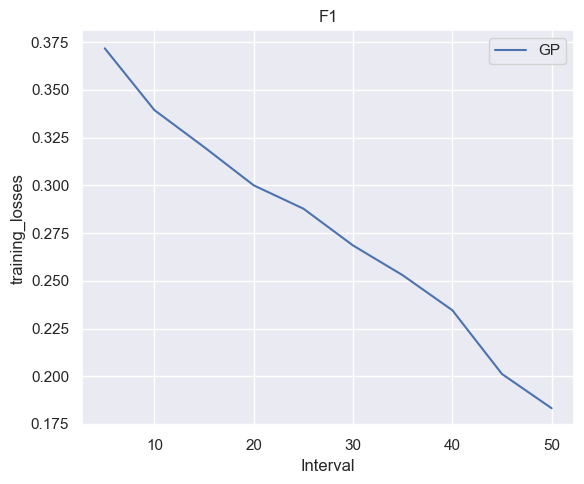

In [31]:
metrics = 'training_losses'
# metrics = 'validation_losses'
# metrics = 'test_losses'
n_datasets = len(results)
record_interval = basic_params['record_interval']
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))


    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.mean(dataset_results[method][metrics], axis=0),
            # dataset_results[method][metrics],
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Interval")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
plt.tight_layout()

plt.show()